In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("https://stooq.pl/q/d/l/?s=vow3.de&d1=20180101&d2=20211231&i=d", parse_dates=["Data"])
data.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,2018-01-02,130.912,131.163,126.737,130.049,1.533116e+06
1,2018-01-03,130.677,134.946,130.425,134.554,1.657879e+06
2,2018-01-04,135.386,137.222,134.428,136.908,1.818363e+06
3,2018-01-05,138.525,141.021,138.368,140.644,2.552202e+06
4,2018-01-08,141.978,142.041,140.597,141.146,1.350856e+06


In [3]:
def make_stationary(x:np.ndarray):
    return 100 * (np.log(x[1:]) - np.log(x[:-1]))

log_returns = make_stationary(data["Zamkniecie"].values)


# Zadanie 1 - histogram zwrotów logarytmicznych

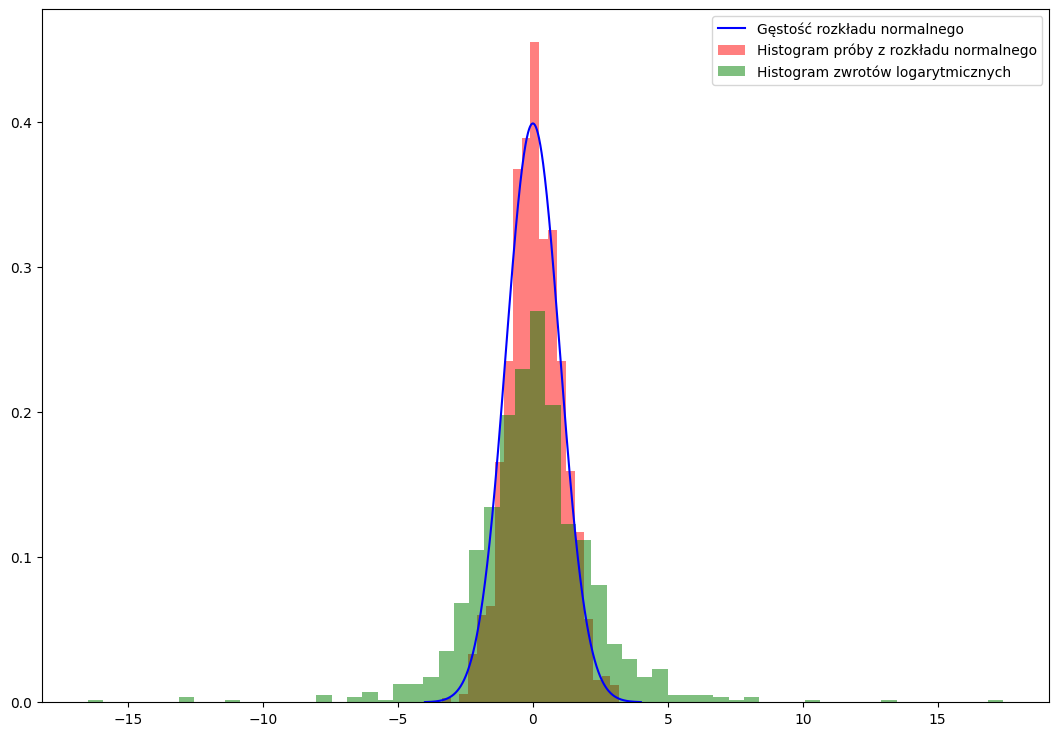

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

N=len(log_returns)
x = stats.norm.rvs(size=N)
num_bins = 20
y = np.linspace(-4, 4, 1000)
bin_width = (x.max() - x.min()) / num_bins

fig, ax = plt.subplots(figsize=(13, 9))
ax.plot(y, stats.norm.pdf(y), color="b", label="Gęstość rozkładu normalnego")
ax.hist(x, density=True, bins=num_bins, facecolor='r', alpha=0.5, label="Histogram próby z rozkładu normalnego")
ax.hist(log_returns, density=True, bins=3*num_bins, facecolor='g', alpha=0.5, label="Histogram zwrotów logarytmicznych")
ax.legend()
plt.show()

# Zadanie 2 - wykres kwantyl-kwantyl

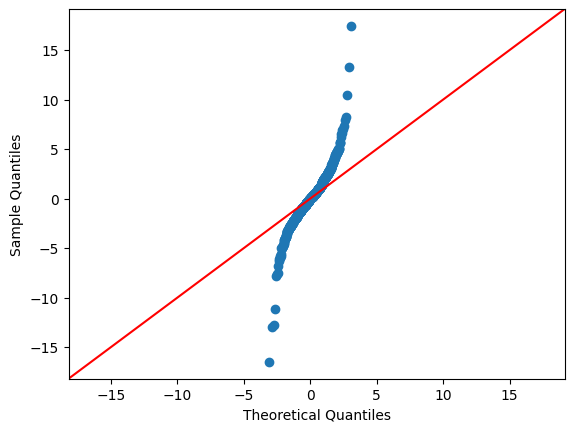

In [5]:
import statsmodels.api as sm 

sm.qqplot(log_returns, line ='45') 
plt.show() 

# Zadanie 3 i 4 - korelogramy

In [71]:
squared_log_returns = pd.Series(log_returns**2, name="squared log returns")
log_returns = pd.Series(log_returns, name="log returns")


log_returns_autocorr = np.array([(i, log_returns.autocorr(lag=i)) for i in range(1,21)])
squared_log_returns_autocorr = np.array([(i, squared_log_returns.autocorr(lag=i)) for i in range(1,21)])

In [72]:
import seaborn as sns
import statsmodels

ljungbox_boxpierce = statsmodels.stats.diagnostic.acorr_ljungbox(log_returns, lags=list(range(1,21)), boxpierce=True, model_df=0, period=None, return_df=True, auto_lag=False)
confidence = 0.95

both_tests_agree = ljungbox_boxpierce[(ljungbox_boxpierce["lb_pvalue"] > 1-confidence) & (ljungbox_boxpierce["bp_pvalue"] > 1-confidence)]
set(ljungbox_boxpierce[(ljungbox_boxpierce["bp_pvalue"] > 1-confidence)].index) == set(ljungbox_boxpierce[(ljungbox_boxpierce["lb_pvalue"] > 1-confidence)].index)

True

In [73]:
both_tests_agree

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.169953,0.140731,2.163514,0.141321
2,2.525771,0.282837,2.517924,0.283949
3,2.839434,0.417049,2.830036,0.418579
4,5.045224,0.282689,5.022735,0.284973
5,5.166099,0.395948,5.142773,0.398706


In [74]:
np.array(list(set(ljungbox_boxpierce.index).difference(both_tests_agree.index)))

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

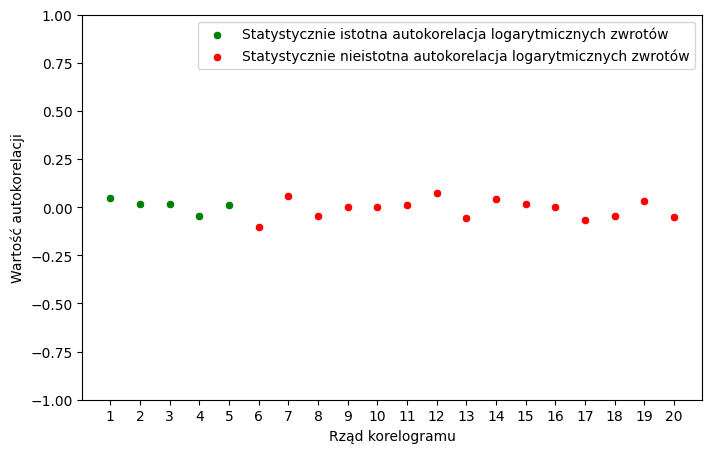

In [75]:
not_significant = np.array(sorted(list(set(ljungbox_boxpierce.index-1).difference(set(both_tests_agree.index-1)))))
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=log_returns_autocorr[both_tests_agree.index-1,0], y=log_returns_autocorr[both_tests_agree.index-1,1], label="Statystycznie istotna autokorelacja logarytmicznych zwrotów", c="g", ax=ax)
sns.scatterplot(x=log_returns_autocorr[not_significant,0], y=log_returns_autocorr[not_significant,1], label="Statystycznie nieistotna autokorelacja logarytmicznych zwrotów", c="r", ax=ax)
ax.set_xticks(log_returns_autocorr[:,0])
ax.set_ylabel("Wartość autokorelacji")
ax.set_xlabel("Rząd korelogramu")
ax.set_ylim(-1.0, 1.0)
plt.show()

In [76]:
import statsmodels

ljungbox_boxpierce = statsmodels.stats.diagnostic.acorr_ljungbox(squared_log_returns, lags=list(range(1,21)), boxpierce=True, model_df=0, period=None, return_df=True, auto_lag=False)
confidence = 0.95

both_tests_agree = ljungbox_boxpierce[(ljungbox_boxpierce["lb_pvalue"] > 1-confidence) & (ljungbox_boxpierce["bp_pvalue"] > 1-confidence)]
set(ljungbox_boxpierce[(ljungbox_boxpierce["bp_pvalue"] > 1-confidence)].index) == set(ljungbox_boxpierce[(ljungbox_boxpierce["lb_pvalue"] > 1-confidence)].index)

True

In [77]:
both_tests_agree

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.866426,0.351947,0.863855,0.352662


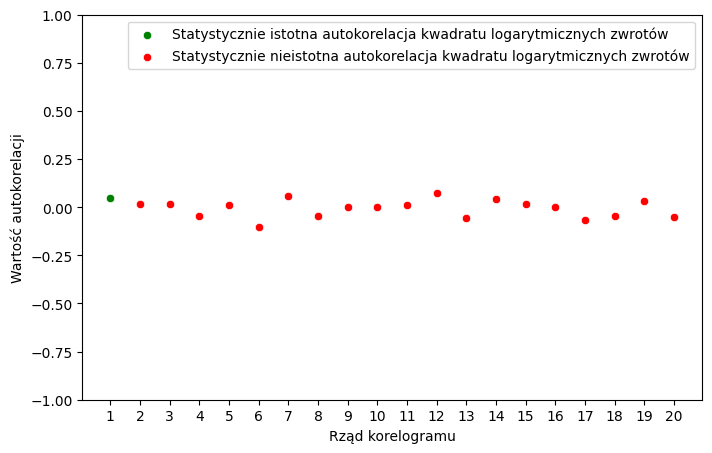

In [78]:
not_significant = np.array(sorted(list(set(ljungbox_boxpierce.index-1).difference(set(both_tests_agree.index-1)))))
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=log_returns_autocorr[both_tests_agree.index-1,0], y=log_returns_autocorr[both_tests_agree.index-1,1], label="Statystycznie istotna autokorelacja kwadratu logarytmicznych zwrotów", c="g", ax=ax)
sns.scatterplot(x=log_returns_autocorr[not_significant,0], y=log_returns_autocorr[not_significant,1], label="Statystycznie nieistotna autokorelacja kwadratu logarytmicznych zwrotów", c="r", ax=ax)
ax.set_xticks(log_returns_autocorr[:,0])
ax.set_ylabel("Wartość autokorelacji")
ax.set_xlabel("Rząd korelogramu")
ax.set_ylim(-1.0, 1.0)
plt.show()